**В рамках дипломного проекта предстояло подготовить исследование для компании «Мегафон».**

Компания «Мегафон» хочет повысить удовлетворённость своих клиентов качеством услуг. Это важная задача для удержания пользователей — как давних, так и недавно привлечённых. Чтобы делать это наиболее эффективно, важно определить, какие технические показатели качества связи сильнее всего влияют на удовлетворённость клиентов. Для этого «Мегафон» провёл опрос своих клиентов, предложив им оценить уровень удовлетворённости качеством связи. По каждому клиенту, прошедшему опрос, были собраны технические показатели. 

**Задача**:
- проанализировать, как зависит (и зависит ли) оценка, которую ставит клиент в опросе, от технических показателей, которые были собраны. 

**Более подробно о проведённом опросе:**
В ходе опроса компания «Мегафон» предложила своим клиентам оценить уровень удовлетворённости качеством связи по десятибалльной шкале (где 10 — это «отлично», а 1 — «ужасно»). Если клиент оценивал качество связи на 9 или 10 баллов, опрос заканчивался. Если клиент ставил оценку ниже 9, задавался второй вопрос — о причинах неудовлетворённости качеством связи с предоставленными пронумерованными вариантами ответа. Ответ можно было дать в свободном формате или перечислить номера ответов через запятую. 




In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
import numpy as np

import plotly.express as px
import plotly.graph_objects as go

import scipy.stats as st
from scipy.stats import shapiro
from tqdm.auto import tqdm
from scipy.stats import norm
from scipy.stats import ttest_ind

In [2]:
from IPython.core.pylabtools import figsize
figsize(14, 7)

In [3]:
df_original = pd.read_csv('megafon.csv')
df_original

user_id  Q1          Q2  Total Traffic(MB)  Downlink Throughput(Kbps)  \
0           1   5         NaN          775.48846                     360.13   
1           2   5           4          861.96324                    3023.54   
2           3   1           4          261.11860                     790.96   
3           4   8           3          179.18564                    2590.97   
4           5   2     2, 3, 4          351.99208                     731.61   
...       ...  ..         ...                ...                        ...   
3107     3108   3     1, 4, 5          519.96475                    1045.70   
3108     3109   3  1, 3, 4, 5          171.52629                     670.32   
3109     3110  10         NaN          187.44936                     590.29   
3110     3111   6        1, 3          827.74515                    1841.90   
3111     3112   6         NaN          596.22757                    2196.00   

      Uplink Throughput(Kbps)  Downlink TCP Retransmission Rate(%)  \
0                       86.56                                 3.93   
1                      411.18                                 1.27   
2                       34.20                                 1.79   
3                      325.88                                 0.80   
4                      223.54                                 1.15   
...                       ...                                  ...   
3107                    44.61                                 0.47   
3108                    40.94                                 2.35   
3109                   186.36                                 2.06   
3110                   373.53                                 1.21   
3111                   265.87                                 0.41   

      Video Streaming Download Throughput(Kbps)  \
0                                       1859.15   
1                                        667.47   
2                                       1079.60   
3                                       7053.81   
4                                       4550.38   
...                                         ...   
3107                                    4523.66   
3108                                    1711.54   
3109                                    3182.83   
3110                                    5675.93   
3111                                    9295.59   

      Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
0                                    2309                             1007.82   
1                                    2080                              255.36   
2                                    6367                              535.85   
3                                    3218                             1221.02   
4                                    1767                             2336.56   
...                                   ...                                 ...   
3107                                 1468                             1044.66   
3108                                 2780                              954.91   
3109                                 2195                             1094.62   
3110                                 1905                             2361.88   
3111                                 2036                             5009.29   

      Web Average TCP RTT(ms)  
0                          83  
1                         425  
2                         485  
3                          51  
4                          68  
...                       ...  
3107                      304  
3108                      251  
3109                      109  
3110                      202  
3111                      156  

[3112 rows x 11 columns]

In [4]:
# проверим на дубликаты
df = df_original.drop_duplicates()
print(df.shape)
print(df_original.shape)
# дубликатов нет

(3112, 11)
(3112, 11)


In [5]:
# процент пропущенных значений 
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print(f'{col} - {round(pct_missing*100)}%')

user_id - 0.0%
Q1 - 0.0%
Q2 - 58.0%
Total Traffic(MB) - 0.0%
Downlink Throughput(Kbps) - 0.0%
Uplink Throughput(Kbps) - 0.0%
Downlink TCP Retransmission Rate(%) - 0.0%
Video Streaming Download Throughput(Kbps) - 0.0%
Video Streaming xKB Start Delay(ms) - 0.0%
Web Page Download Throughput(Kbps) - 0.0%
Web Average TCP RTT(ms) - 0.0%


In [6]:
# описательная статистика
df_desc = df.iloc[:, 3:].describe()
df_desc

Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
count        3112.000000                3112.000000              3112.000000   
mean          406.282339                2220.774023               170.702381   
std           220.593815                2629.824405               204.031286   
min           100.026680                  13.260000                 6.110000   
25%           214.261193                 652.297500                70.735000   
50%           363.999720                1404.230000               119.435000   
75%           572.524325                2823.645000               210.617500   
max           887.078270               39817.640000              4141.850000   

       Downlink TCP Retransmission Rate(%)  \
count                          3112.000000   
mean                              1.834518   
std                               2.074593   
min                               0.050000   
25%                               0.720000   
50%                               1.300000   
75%                               2.240000   
max                              31.200000   

       Video Streaming Download Throughput(Kbps)  \
count                                3112.000000   
mean                                 5728.806848   
std                                  5161.475235   
min                                     0.000000   
25%                                  2324.550000   
50%                                  4436.500000   
75%                                  7611.440000   
max                                 58566.030000   

       Video Streaming xKB Start Delay(ms)  \
count                          3112.000000   
mean                           2107.596080   
std                            1582.423057   
min                             239.000000   
25%                            1280.000000   
50%                            1672.000000   
75%                            2312.000000   
max                           21392.000000   

       Web Page Download Throughput(Kbps)  Web Average TCP RTT(ms)  
count                         3112.000000              3112.000000  
mean                          2100.258901               194.195051  
std                           2062.509549               267.387914  
min                              0.000000                 0.000000  
25%                           1018.002500                74.000000  
50%                           1670.695000               118.000000  
75%                           2519.987500               207.000000  
max                          35603.970000              3471.000000

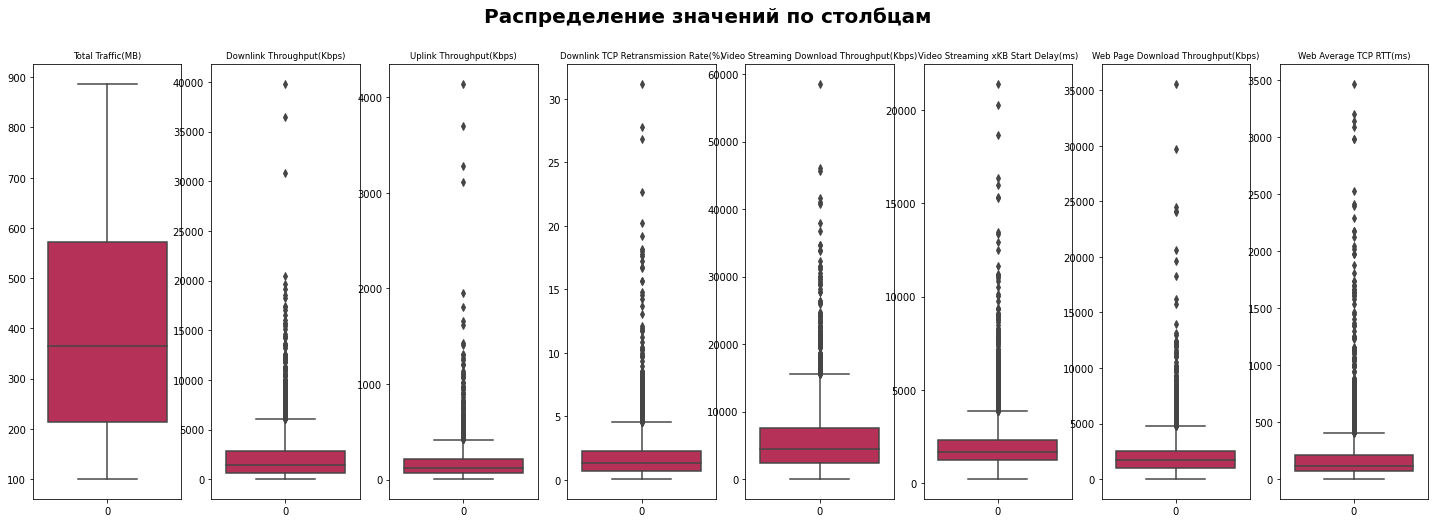

In [7]:
# посмотрим на распределение данных в числовых столбцах
fig, axes = plt.subplots(1, 8, figsize=(25,8))
plt.suptitle('Распределение значений по столбцам', fontsize = 20, fontweight = 'bold')
 
x = 0
for column in df.iloc[:,3:]:
    sns.boxplot(data = df[column], ax=axes[x], orient='V', palette = 'rocket').set_title(column, fontsize=8.5)
    x+=1

В данных есть значительные выбросы, заменим их на среднее значение. Но сначала отберем валидные данные. 


Поскольку ответ на первый вопрос подразумевает одну цифру, отберем записи с длинной 1 и значениями не равными 0 так как ожидаемые оценки от 1 до 10, так же был обнаружен один знак '?' его тоже исключим в фильтре.

In [8]:
# фильтр по валидным данным в столбце с первым вопросом 
df = df[(df['Q1'].str.len() == 1) & (df['Q1'] != '0') & (df['Q1'] != '?')]

Далее отделим столбцы с вопросами от столбцов с техническим показателям. 
К столбцам с техническими показателями применим функцию по замене выбросов на среднее значение по группам оценок. 

In [9]:
# отделяем колонки с вопросами 
col_q = df.loc[:,['Q1', 'Q2']]

In [10]:
# функция для замены выбросов на средние значения
def replace(group):
    mean, std = group.mean(), group.std()
    outliers = (group - mean).abs() > 3*std
    group[outliers] = mean
    return group

In [11]:
main_processed = df.groupby('Q1').transform(replace)
main_processed.head()

user_id  Total Traffic(MB)  Downlink Throughput(Kbps)  \
0        1          775.48846                     360.13   
1        2          861.96324                    3023.54   
2        3          261.11860                     790.96   
3        4          179.18564                    2590.97   
4        5          351.99208                     731.61   

   Uplink Throughput(Kbps)  Downlink TCP Retransmission Rate(%)  \
0                    86.56                                 3.93   
1                   411.18                                 1.27   
2                    34.20                                 1.79   
3                   325.88                                 0.80   
4                   223.54                                 1.15   

   Video Streaming Download Throughput(Kbps)  \
0                                    1859.15   
1                                     667.47   
2                                    1079.60   
3                                    7053.81   
4                                    4550.38   

   Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
0                               2309.0                             1007.82   
1                               2080.0                              255.36   
2                               6367.0                              535.85   
3                               3218.0                             1221.02   
4                               1767.0                             2336.56   

   Web Average TCP RTT(ms)  
0                     83.0  
1                    425.0  
2                    485.0  
3                     51.0  
4                     68.0

In [12]:
# соединяем 2 дф 
main = col_q.join(main_processed).drop('user_id', axis = 1)
main_desc = main.describe()
main_desc

Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
count        2212.000000                2212.000000              2212.000000   
mean          406.874669                1876.293963               151.652671   
std           220.219906                1771.340855               120.047627   
min           100.035380                  13.260000                 6.110000   
25%           214.712665                 619.152500                68.560000   
50%           365.108435                1323.820000               116.835000   
75%           571.239005                2521.585000               199.152500   
max           887.078270               11982.090000               975.560000   

       Downlink TCP Retransmission Rate(%)  \
count                          2212.000000   
mean                              1.697406   
std                               1.354779   
min                               0.060000   
25%                               0.740000   
50%                               1.330000   
75%                               2.212500   
max                              10.880000   

       Video Streaming Download Throughput(Kbps)  \
count                                2212.000000   
mean                                 5141.822585   
std                                  4012.876656   
min                                     0.000000   
25%                                  2142.767500   
50%                                  4210.315000   
75%                                  7096.815000   
max                                 24394.920000   

       Video Streaming xKB Start Delay(ms)  \
count                          2212.000000   
mean                           2037.209633   
std                            1113.539984   
min                             375.000000   
25%                            1315.000000   
50%                            1704.500000   
75%                            2349.250000   
max                            7519.000000   

       Web Page Download Throughput(Kbps)  Web Average TCP RTT(ms)  
count                         2212.000000              2212.000000  
mean                          1850.740557               174.560777  
std                           1281.750584               159.023630  
min                              0.000000                 0.000000  
25%                            959.305000                77.000000  
50%                           1606.125000               123.000000  
75%                           2404.912500               209.000000  
max                           9164.490000              1446.000000

Посмотрим какие данные изменились в таблице описательной статистики

In [13]:
desc = df_desc - main_desc
desc.loc[(desc != 0).any(1)]

Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
count         900.000000                 900.000000               900.000000   
mean           -0.592330                 344.480060                19.049710   
std             0.373909                 858.483551                83.983659   
min            -0.008700                   0.000000                 0.000000   
25%            -0.451472                  33.145000                 2.175000   
50%            -1.108715                  80.410000                 2.600000   
75%             1.285320                 302.060000                11.465000   
max             0.000000               27835.550000              3166.290000   

       Downlink TCP Retransmission Rate(%)  \
count                           900.000000   
mean                              0.137112   
std                               0.719814   
min                              -0.010000   
25%                              -0.020000   
50%                              -0.030000   
75%                               0.027500   
max                              20.320000   

       Video Streaming Download Throughput(Kbps)  \
count                                 900.000000   
mean                                  586.984262   
std                                  1148.598579   
min                                     0.000000   
25%                                   181.782500   
50%                                   226.185000   
75%                                   514.625000   
max                                 34171.110000   

       Video Streaming xKB Start Delay(ms)  \
count                           900.000000   
mean                             70.386447   
std                             468.883073   
min                            -136.000000   
25%                             -35.000000   
50%                             -32.500000   
75%                             -37.250000   
max                           13873.000000   

       Web Page Download Throughput(Kbps)  Web Average TCP RTT(ms)  
count                          900.000000               900.000000  
mean                           249.518344                19.634275  
std                            780.758965               108.364284  
min                              0.000000                 0.000000  
25%                             58.697500                -3.000000  
50%                             64.570000                -5.000000  
75%                            115.075000                -2.000000  
max                          26439.480000              2025.000000

Далее построим график, который поможет наглядно оценить каких оценок больше после первого вопроса.

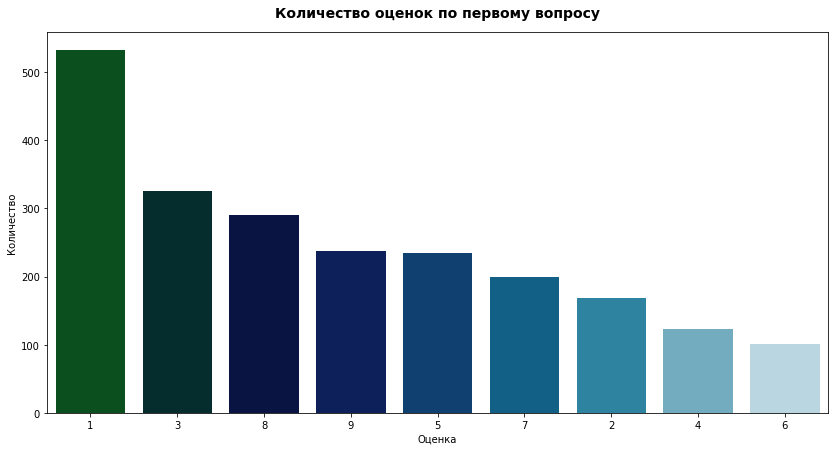

In [14]:
points = main['Q1'].value_counts().reset_index()

sns.barplot(x='index', y='Q1', data=points,  palette='ocean')
plt.title(f'Количество оценок по первому вопросу',fontweight='bold', fontsize=14, pad=15)
plt.xlabel('Оценка')
plt.ylabel('Количество');

**Большинство  опрошенных оценили качество связи низким баллом**

In [15]:
# изменим тип данных в столбце Q1 
main['Q1'] = main['Q1'].astype(int)
main_2 = main.copy(deep=True) # делаем глубокую копию на будущее 

Для дальнейшей работы необходимо разделить респондентов на группы. 

- Группа А - те, кто поставил 9 или 10 баллов после первого вопроса
- Группа В - те, кто поставил оценки ниже 9 после первого вопроса

In [16]:
# кодируем группы 
main['Q1'] = np.where(main['Q1'] >= 9, 'A', 'B')

Для анализа отберем столбцы значения в которых можно описать как "Чем меньше, тем лучше"

In [17]:
col_min = main.loc[:, ['Q1','Downlink TCP Retransmission Rate(%)', 'Video Streaming xKB Start Delay(ms)', 'Web Average TCP RTT(ms)']]
col_min.head()

Q1  Downlink TCP Retransmission Rate(%)  \
0  B                                 3.93   
1  B                                 1.27   
2  B                                 1.79   
3  B                                 0.80   
4  B                                 1.15   

   Video Streaming xKB Start Delay(ms)  Web Average TCP RTT(ms)  
0                               2309.0                     83.0  
1                               2080.0                    425.0  
2                               6367.0                    485.0  
3                               3218.0                     51.0  
4                               1767.0                     68.0

In [18]:
# посмотрим как различаются среднее по отобранным показателям  
plot_df = col_min.groupby(['Q1']).agg({'mean'})

plot_df.T.style.applymap(lambda x: "background-color: coral" if x > 1700 else " ")

Наиболее сильно отличаются средние по показателю Video Streaming xKB Start Delay(ms)

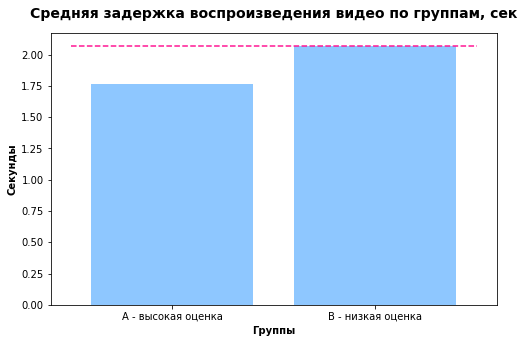

In [22]:
num_A = plot_df.T.iloc[1][0] / 1000  # переводим в секунды
num_B = plot_df.T.iloc[1][1] / 1000  # переводим в секунды

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(["A - высокая оценка", "B - низкая оценка"],[num_A, num_B], 
          color='dodgerblue', alpha=0.5)
plt.title('Средняя задержка воспроизведения видео по группам, сек',
          fontweight='bold', fontsize=14, pad=15)
plt.xlabel("Группы", fontweight='bold')
plt.ylabel("Секунды", fontweight='bold')
plt.hlines(num_B, -0.5, 1.5, linestyle='--', color='deeppink');

Предположим, что из-за чуть дольшего ожидания перед воспроизведением видео клиенты могут ставить низкие оценки. 
- Но: между группами разницы нет, разница во времени не влияет на оценку, которую поставили респонденты
- Н1: между группами разница есть, время задержки влияет на оценку, которую поставили респонденты 

In [23]:
# функция бутстрапа 
def bootstrap(arr,n=100,N_TRIAL = 1000,func = np.mean):
    res = []
    n = min(len(arr),n)
    # инициализируем цикл попыток
    for _ in range(N_TRIAL):
        # делаем подвыборку размера n
        if len(arr.shape)>1:
            ind = np.random.choice(np.arange(arr.shape[0]), size = (n,))
            subsample = arr.iloc[ind]
        else:
            subsample = np.random.choice(arr, size = (n,))
        # рассчитываем статистику
        stat = func(subsample)
        res.append(stat)
    return res 

In [24]:
# отбираем группы 
a = col_min[col_min['Q1'] == "A"]['Video Streaming xKB Start Delay(ms)']
b = col_min[col_min['Q1'] == "B"]['Video Streaming xKB Start Delay(ms)']

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


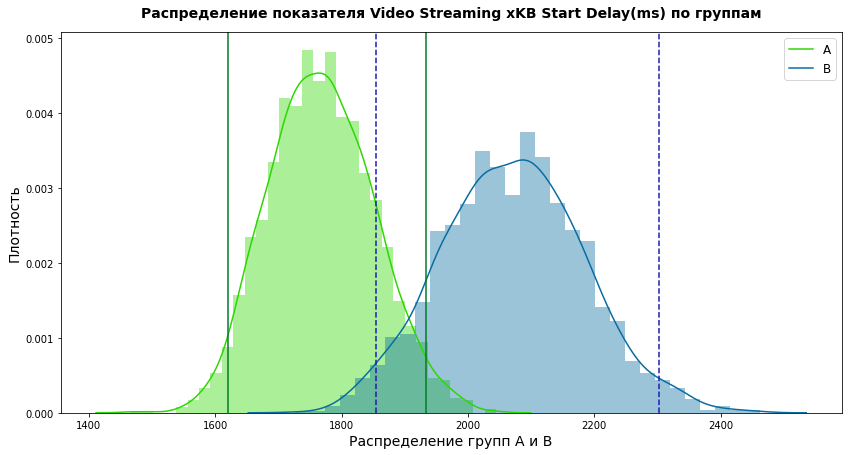

In [25]:
# применим функцию бутстрапа, отобразим распределение и доверительные интервалы 
samples_a = bootstrap(a, N_TRIAL = 2000)
samples_b = bootstrap(b, N_TRIAL = 2000)


ax = sns.distplot(samples_a, label = 'A', color = '#2DD700')
sns.distplot(samples_b,ax = ax, label = 'B', color = '#086CA2')
ax.legend(['A','B'], fontsize = 12)
plt.title('Распределение показателя Video Streaming xKB Start Delay(ms) по группам', fontweight = 'bold', fontsize = 14, pad=15)
plt.xlabel('Распределение групп А и В', fontsize = 14)
plt.ylabel('Плотность', fontsize = 14)
ax.axvline(np.percentile(samples_a,2.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(samples_a,97.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(samples_b,2.5), linestyle = '--', color='#1F1AB2')
ax.axvline(np.percentile(samples_b,97.5), linestyle = '--', color='#1F1AB2');

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


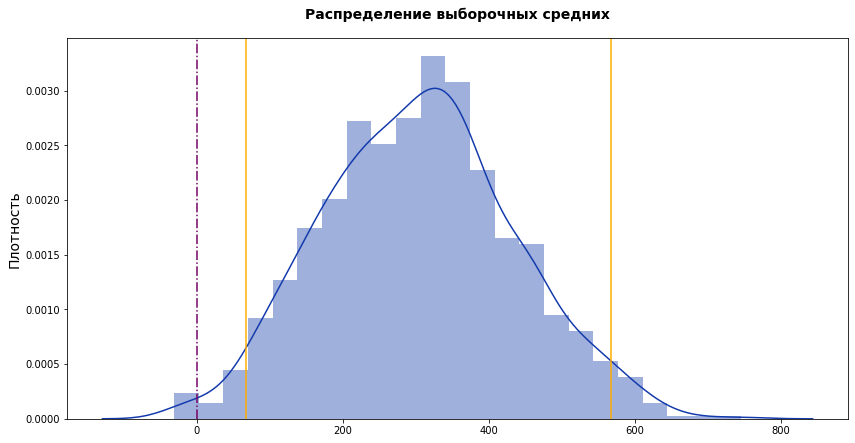

In [26]:
# найдем разницу выборочных средних
buf = []
for i in range(1000):
    a_sample =  a.sample(100)
    b_sample =  b.sample(100)
    buf.append(np.mean(b_sample)-np.mean(a_sample))
 

ax_buf = sns.distplot(buf, color = '#133AAC')
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(0, color = '#730065', linestyle  = '-.')
plt.title('Распределение выборочных средних', fontsize = 14, fontweight = 'bold', pad = 20)
plt.ylabel('Плотность', fontsize = 14);

Проведем статистический тест.

Внешне распределения в группах после бутстрапа выглядят нормальными, так что к ним можно применить критерий Стьюдента. 

Основные требования к распределению:
- Сравниваемые выборки должны происходить из нормально распределенных совокупностей;
- Дисперсии сравниваемых генеральных совокупностей должны быть равны.
- Предполагается независимость сравниваемых выборок.

Поскольку дисперсии сравниваемых генеральных совокупностей нам не известны. Используем модификацию t-критерия -  критерий Уэлча, он используется для выборок с разными дисперсиями. 

In [27]:
# применим модифицированный t-тест с (equal_var = False)
stat, p = ttest_ind(samples_a, samples_b, equal_var = False)
print(f'Statistic={round(stat,4)}, p_value={round(p,4)}')

Statistic=-96.9937, p_value=0.0


### Вывод:  Ноль не входит доверительный интервал, p_value< 0.05, значит мы можем утверждать что оценка качества связи зависит от задержки во времени при воспроизведении видео. (Video Streaming xKB Start Delay(ms))

Отберем значения показания которых можно охарактеризовать "чем выше, тем лучше".

In [29]:
col_max = main.loc[:, ['Q1','Total Traffic(MB)', 'Downlink Throughput(Kbps)', 'Uplink Throughput(Kbps)', 
                      'Video Streaming Download Throughput(Kbps)', 'Web Page Download Throughput(Kbps)']]
col_max.head()

Q1  Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
0  B          775.48846                     360.13                    86.56   
1  B          861.96324                    3023.54                   411.18   
2  B          261.11860                     790.96                    34.20   
3  B          179.18564                    2590.97                   325.88   
4  B          351.99208                     731.61                   223.54   

   Video Streaming Download Throughput(Kbps)  \
0                                    1859.15   
1                                     667.47   
2                                    1079.60   
3                                    7053.81   
4                                    4550.38   

   Web Page Download Throughput(Kbps)  
0                             1007.82  
1                              255.36  
2                              535.85  
3                             1221.02  
4                             2336.56

Pассчитаем разницу между средними значениями по группам 

In [30]:
col_max.groupby(['Q1']).agg({'mean'}).T['A'] - col_max.groupby(['Q1']).agg({'mean'}).T['B']

Total Traffic(MB)                          mean     -12.950107
Downlink Throughput(Kbps)                  mean     494.866858
Uplink Throughput(Kbps)                    mean      23.102831
Video Streaming Download Throughput(Kbps)  mean    1260.050380
Web Page Download Throughput(Kbps)         mean     375.908294
dtype: float64

Среди средних значений по столбцам где значения можно проинтерпретировать "чем выше, тем лучше" есть значительные различия в показателе Video Streaming Download Throughput(Kbps)

In [31]:
# распределение данных в столбце Video Streaming Download Throughput(Kbps)

fig = go.Figure()
fig.add_trace(go.Histogram(x=col_max['Video Streaming Download Throughput(Kbps)'],
                           opacity=0.75, xbins=dict(start=50, end=900, size=50)))

fig.update_layout(barmode='stack',
                  title_text='Распределение столбцу Video Streaming Download Throughput(Kbps)',
                  xaxis_title="Скорость, Kbps",
                  yaxis_title='Количество пользователей')
fig.show()

Предположим, что различия в показателе Video Streaming Download Throughput(Kbps) оказывают влияние на оценку респондентов.

- Но: между группами разницы нет, разница в скорости загрузки потокового видео не влияет на оценку, которую поставили респонденты
- Н1: между группами разница есть, скорость загрузки влияет на оценку, которую поставили респонденты 

In [32]:
# отберем группы a_2 и b_2
a_2 = col_max[col_max['Q1'] == 'A']['Video Streaming Download Throughput(Kbps)']
b_2 = col_max[col_max['Q1'] == 'B']['Video Streaming Download Throughput(Kbps)']

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



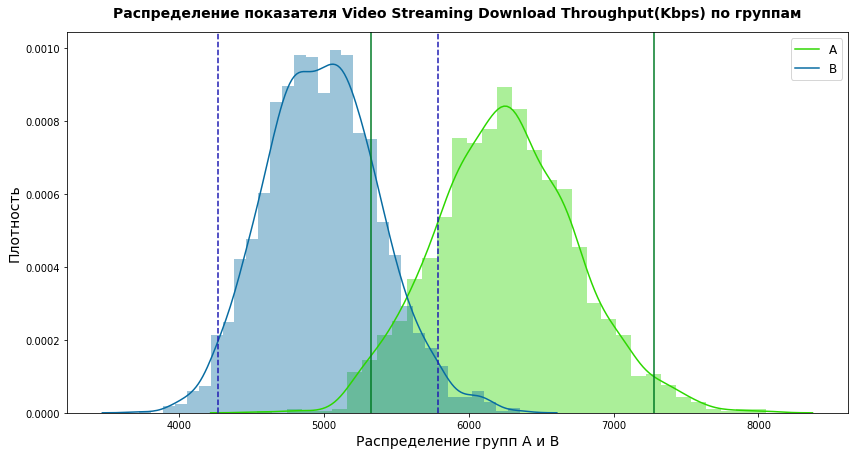

In [33]:
# применим функцию бутстрапа, отобразим распределение и доверительные интервалы 
samples_a = bootstrap(a_2, N_TRIAL = 2000)
samples_b = bootstrap(b_2, N_TRIAL = 2000)


ax = sns.distplot(samples_a, label = 'A', color = '#2DD700')
sns.distplot(samples_b,ax = ax, label = 'B', color = '#086CA2')
ax.legend(['A','B'], fontsize = 12)
plt.title('Распределение показателя Video Streaming Download Throughput(Kbps) по группам', fontweight = 'bold', fontsize = 14, pad=15)
plt.ylabel('Плотность', fontsize = 14)
plt.xlabel('Распределение групп A и В', fontsize = 14)
ax.axvline(np.percentile(samples_a,2.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(samples_a,97.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(samples_b,2.5), linestyle = '--', color='#1F1AB2')
ax.axvline(np.percentile(samples_b,97.5), linestyle = '--', color='#1F1AB2');

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



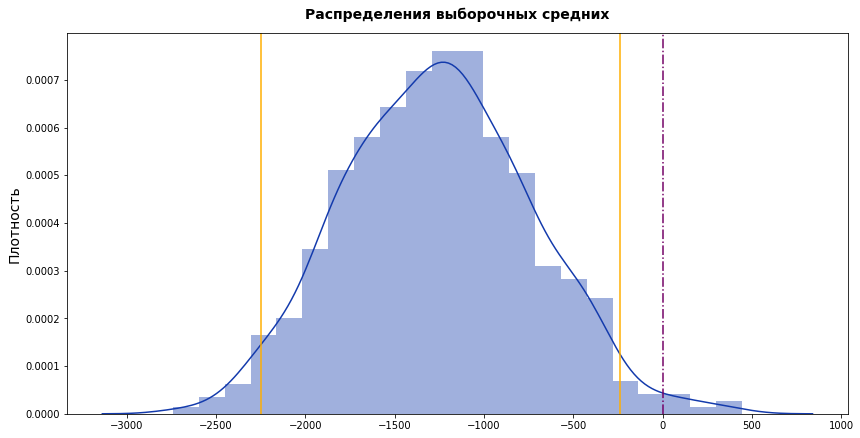

In [34]:
buf = []
for i in range(1000):
    a_sample =  a_2.sample(100)
    b_sample =  b_2.sample(100)
    buf.append(np.mean(b_sample)-np.mean(a_sample))
    
ax_buf = sns.distplot(buf, color = '#133AAC')
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(0, color = '#730065', linestyle  = '-.')
plt.title('Распределение выборочных средних', fontsize = 14, fontweight = 'bold', pad = 15)
plt.ylabel('Плотность', fontsize = 14);

Проведем статистический тест на данных которые были отобраны но без применения бутстрапа.

Для этого мы применим критерий U-критерий Манна — Уитни непараметрический статистический критерий, используемый для оценки различий между двумя выборками по признаку, измеренному в количественной или порядковой шкале. Данный критерий является непараметрическим аналогом t-теста, он не требователен к распределению, можно пренебречь равенством дисперсий и размеры групп могут быть различны. 

Ограничения применимости критерия.
- В каждой из выборок должно быть не менее 5 значений признака. 
- В выборочных данных не должно быть совпадающих значений или таких совпадений должно быть мало.

In [35]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(a_2, b_2)
print(f'Statistics={stat}, p_value={round(p,4)}')

Statistics=200348.0, p_value=0.0001


### Вывод: ноль не входит в доверительный интервал, а U-критерий Манна — Уитни показал p_value = 0.0001, значит можно сделать вывод о том, что скорость загрузки потокового видео влияет на оценку которую поставили респонденты. 

Какие технические показатели сильнее всего отличаются у групп если их разделить по баллу?

In [37]:
# сгруппируем по баллу и посчитаем среднее значение в каждой группе 
mark_mean = main_2.groupby('Q1').mean().reset_index()
mark_mean

Q1  Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
0   1         408.498644                1701.723825               135.192637   
1   2         373.217978                1517.956086               130.878271   
2   3         394.143874                1622.280577               150.702403   
3   4         453.954045                1882.823920               147.097755   
4   5         427.094451                1826.741982               153.337266   
5   6         461.131348                2370.599530               175.841382   
6   7         399.291951                1962.125446               157.612472   
7   8         397.227967                2131.349928               166.016408   
8   9         395.317929                2317.915653               172.269754   

   Downlink TCP Retransmission Rate(%)  \
0                             1.886567   
1                             1.857134   
2                             1.801533   
3                             1.764985   
4                             1.673315   
5                             1.498833   
6                             1.615292   
7                             1.483812   
8                             1.422822   

   Video Streaming Download Throughput(Kbps)  \
0                                4519.569520   
1                                5310.009101   
2                                4283.787532   
3                                4770.330899   
4                                5185.030573   
5                                5755.122834   
6                                5546.550371   
7                                5852.178199   
8                                6266.297925   

   Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
0                          2163.561140                         1643.230331   
1                          2092.977218                         1978.255089   
2                          2173.194083                         1687.893935   
3                          2083.306762                         1786.600147   
4                          2073.417269                         1755.199935   
5                          1848.399275                         2143.961856   
6                          1939.783300                         1956.825579   
7                          1928.161618                         1993.254316   
8                          1765.624126                         2186.203022   

   Web Average TCP RTT(ms)  
0               209.345172  
1               174.699972  
2               195.603351  
3               154.189570  
4               170.400888  
5               156.588962  
6               145.701675  
7               151.304921  
8               142.905233

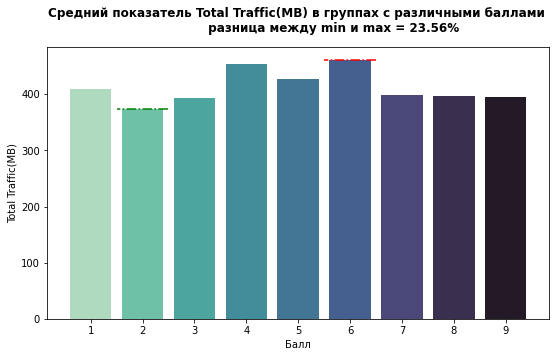

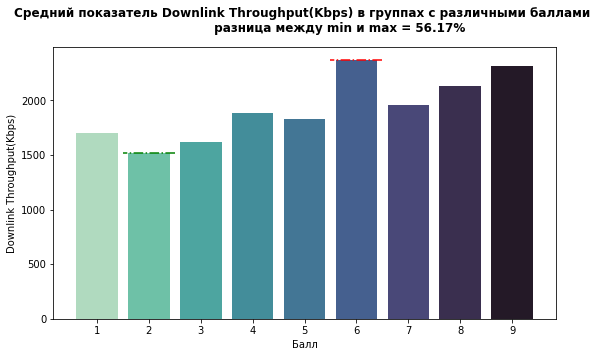

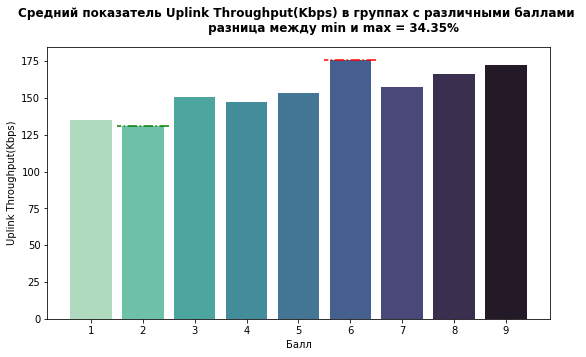

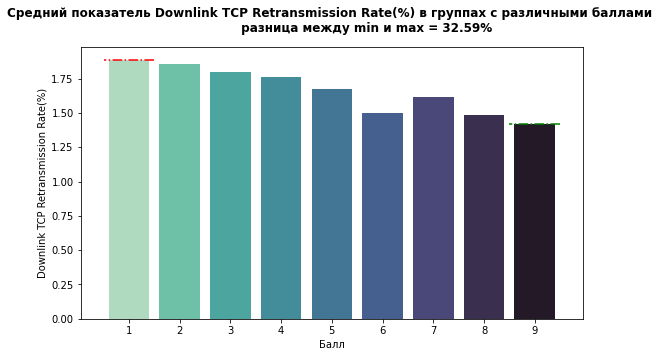

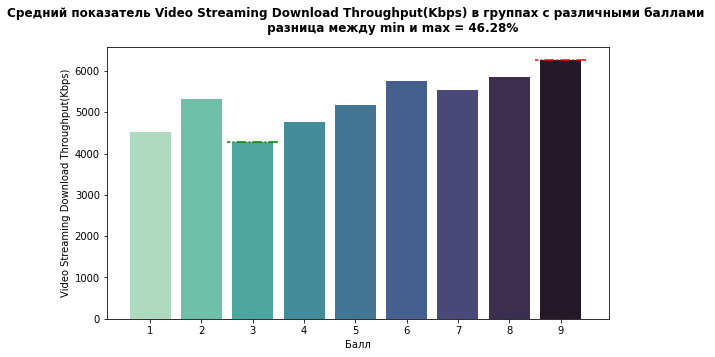

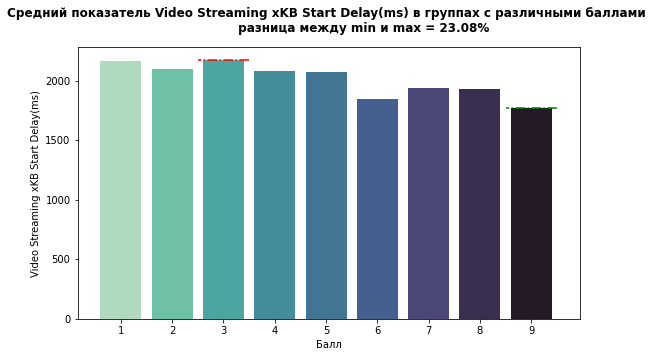

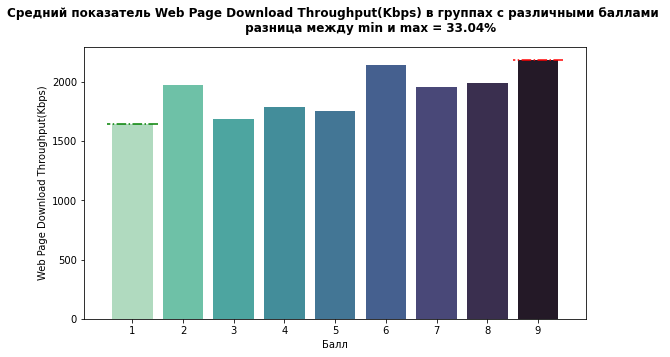

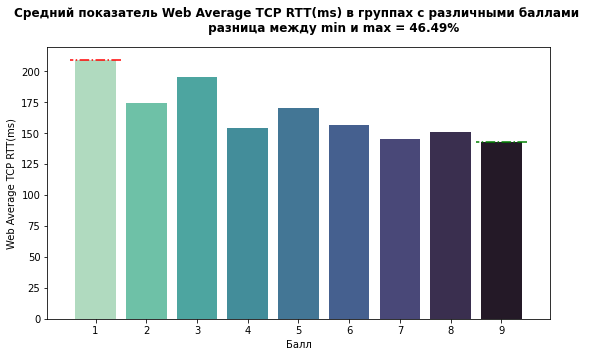

Максимальная разница в ('Downlink Throughput(Kbps)', 56.17)


In [38]:
# построим графики и отметим на них средние показатели по всем техническим показателям, 
# а так же рассчитаем процентную разницу между максимальным и минимальным показателем 

d = {} # словарь для хранения значений процентной разницы и показателя 
for i in mark_mean.iloc[:, 1:]:  # циклом находим разницу между минимальным и максимальным значением средних 
    y = mark_mean[i]
    x = mark_mean['Q1']
    xmin = mark_mean.loc[mark_mean[i] == mark_mean[i].min(), 'Q1'].reset_index()['Q1'][0] # это для графика 
    xmax = mark_mean.loc[mark_mean[i] == mark_mean[i].max(), 'Q1'].reset_index()['Q1'][0] # это для графика
    diff = ((y.max() - y.min()) / y.min()) * 100
    d[i] = round(diff, 2)

    fig,ax = plt.subplots(figsize=(9,5))
    sns.barplot(x=x, y=y, palette = 'mako_r' )
    plt.title(f'Средний показатель {i} в группах с различными баллами \n \
                разница между min и max = {round(diff,2)}%', fontsize = 12, fontweight = 'bold', pad = 15)
    plt.xlabel('Балл')
    plt.hlines(y = mark_mean[i].min(), xmin = xmin-0.5, xmax = xmin - 1.5, color= 'g', linestyle= '-.')
    plt.hlines(y = mark_mean[i].max(), xmin = xmax-0.5, xmax = xmax - 1.5, color= 'r', linestyle= '-.')
    plt.show()
    l=sorted(d.items(), key=lambda x: x[1]) # сортируем словарь
    
print(f'Максимальная разница в {l[-1]}')


Все показатели довольно разнообразно распределены, но насколько объективна оценка показателя Downlink Throughput(Kbps)? 
Проверим гипотезу о том, что разница между всеми группами есть, что оценка поставлена не случайным образом.

- Но: между группами разницы нет, различия в техническом показателе Downlink Throughput(Kbps) не влияет на оценку, которую поставили респонденты. Оценки не объективны. 
- Н1: между группами разница есть, различия в техническом показателе Downlink Throughput(Kbps) влияет на оценку, которую поставили респонденты. Оценки объективны. 

Для этого нужно разделить данные на группы по оценкам, которые они поставили. У нас будет 9 групп.

In [40]:
# делим дф на группы 
n = main_2['Q1'].nunique()

l = []
for i in range(n+1):
    l.append(main_2[main_2['Q1'] == i]['Downlink Throughput(Kbps)'])  

Применим H-критерий Краскела–Уоллиса – это непараметрический аналог однофакторного дисперсионного анализа. Также можно его считать расширением критерия суммы рангов Вилкоксона для более чем двух групп. Этот критерий проверяет гипотезу о равенстве медианы нескольких групп и не требует одинакового объема всех выборок. 

Тест Краскела-Уоллиса позволяет сделать заключение только следующего вида: либо "сравниваемые группы статистически значимо различаются" (например, при Р < 0.05), либо "статистически значимых различий между группами нет" (например, при Р > 0.05). Этот метод сам по себе не позволяет сказать, где именно лежат различия.

In [41]:
from scipy import stats
# отделяем группы 
group_1 = list(l[1])
group_2 = list(l[2]) 
group_3 = list(l[3])
group_4 = list(l[4])
group_5 = list(l[5])
group_6 = list(l[6])
group_7 = list(l[7])
group_8 = list(l[8])
group_9 = list(l[9])

stat, p = stats.kruskal(group_1, group_2, group_3, group_4, group_5, group_6, group_7, group_8, group_9)
print(f'H-statistic = {stat}, p_value = {round(p,4)}')

H-statistic = 45.836159405579366, p_value = 0.0


### Вывод: различия между группами которые разделены по баллам разница есть,  показатель Downlink Throughput(Kbps) влияет на оценку, которые поставили респонденты, медианы групп статистически значимо различаются, но нельзя сказать в каких группах именно. 

Перейдем ко второму вопросу, который был задан респондентам если они оценили качество связи на балл от 1 до 8. 

Для этого потребуется разделить столбец Q2 на строки, в соответствии с тем сколько оценок они выставили после второго вопроса. В каждой строке будет уникальная оценка и но технические данные будут дублироваться.


In [42]:
data = main_2.dropna(subset=['Q2']) 

def score_parse(x):
    import re
    if type(x) == str:
        return [int(v) for v in re.findall(r'\d+', x)]
    else:
        return [x]
data['Q2'] = data['Q2'].apply(lambda x: score_parse(x)) 

from sklearn.preprocessing import MultiLabelBinarizer

q2 = data['Q2']
mlb = MultiLabelBinarizer()
q2_val = pd.DataFrame(mlb.fit_transform(q2), columns=mlb.classes_)
data = pd.concat([data, q2_val], axis =1)

data = data.explode('Q2')
data = data.drop([0,1,2,3,4,5,6,7,10,27,34], axis = 1).dropna()
data['Q2'] = data['Q2'].astype(int)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Отбор записей без вариантов ответа: "Свой вариант", "Затрудняюсь ответить" и другого мусора

In [43]:
q2 = data.loc[~data['Q2'].isin([0, 6, 7, 27, 34, 10])].drop(['Q1'], axis=1)
q2

Q2  Total Traffic(MB)  Downlink Throughput(Kbps)  \
1      4          861.96324                    3023.54   
2      4          261.11860                     790.96   
3      3          179.18564                    2590.97   
4      2          351.99208                     731.61   
4      3          351.99208                     731.61   
...   ..                ...                        ...   
3108   3          171.52629                     670.32   
3108   4          171.52629                     670.32   
3108   5          171.52629                     670.32   
3110   1          827.74515                    1841.90   
3110   3          827.74515                    1841.90   

      Uplink Throughput(Kbps)  Downlink TCP Retransmission Rate(%)  \
1                      411.18                                 1.27   
2                       34.20                                 1.79   
3                      325.88                                 0.80   
4                      223.54                                 1.15   
4                      223.54                                 1.15   
...                       ...                                  ...   
3108                    40.94                                 2.35   
3108                    40.94                                 2.35   
3108                    40.94                                 2.35   
3110                   373.53                                 1.21   
3110                   373.53                                 1.21   

      Video Streaming Download Throughput(Kbps)  \
1                                        667.47   
2                                       1079.60   
3                                       7053.81   
4                                       4550.38   
4                                       4550.38   
...                                         ...   
3108                                    1711.54   
3108                                    1711.54   
3108                                    1711.54   
3110                                    5675.93   
3110                                    5675.93   

      Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
1                                  2080.0                              255.36   
2                                  6367.0                              535.85   
3                                  3218.0                             1221.02   
4                                  1767.0                             2336.56   
4                                  1767.0                             2336.56   
...                                   ...                                 ...   
3108                               2780.0                              954.91   
3108                               2780.0                              954.91   
3108                               2780.0                              954.91   
3110                               1905.0                             2361.88   
3110                               1905.0                             2361.88   

      Web Average TCP RTT(ms)  
1                       425.0  
2                       485.0  
3                        51.0  
4                        68.0  
4                        68.0  
...                       ...  
3108                    251.0  
3108                    251.0  
3108                    251.0  
3110                    202.0  
3110                    202.0  

[2383 rows x 9 columns]

Во втором вопросе есть пункты, которые не связаны с техническими показателями в данных. 

Сравним первичные технические показатели (Downlink TCP Retransmission Rate(%) и Web Average TCP RTT(ms)) для двух групп.


- Первая группа - кого не удовлетворяет только качество связи, а не интернента (ответы 1,2,3)
- Вторая группа - кто полностью доволен услугами (ответы 9,10)

Отберем записи и сразу применим функцию bootstrap 

In [44]:
# группа А: кто поставил после второго вопроса 1, 2, 3
group_a = bootstrap(data.loc[data['Q2'].isin([1, 2, 3])]['Downlink TCP Retransmission Rate(%)'],  N_TRIAL = 3000)
# группа В: кто поставил оценки 9 или 10 на первый вопрос 
group_b = bootstrap(main_2.loc[main_2['Q1'].isin([9, 10])]['Downlink TCP Retransmission Rate(%)'], N_TRIAL = 3000)

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



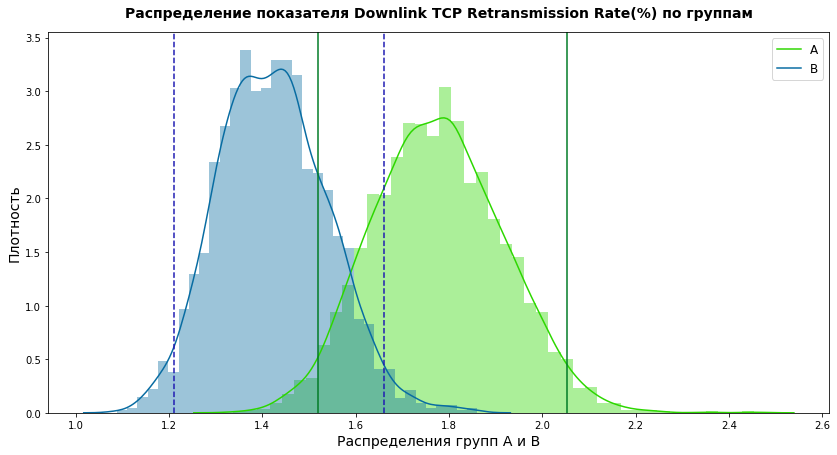

In [45]:
ax = sns.distplot(group_a, label = 'A', color = '#2DD700')
sns.distplot(group_b,ax = ax, label = 'B', color = '#086CA2')
ax.legend(['A','B'], fontsize = 12)
plt.title('Распределение показателя Downlink TCP Retransmission Rate(%) по группам', fontweight = 'bold', fontsize = 14, pad=15)
plt.xlabel('Распределения групп А и В', fontsize = 14)
plt.ylabel('Плотность', fontsize = 14)
ax.axvline(np.percentile(group_a,2.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(group_a,97.5), linestyle = '-', color='#007B25')
ax.axvline(np.percentile(group_b,2.5), linestyle = '--', color='#1F1AB2')
ax.axvline(np.percentile(group_b,97.5), linestyle = '--', color='#1F1AB2');

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



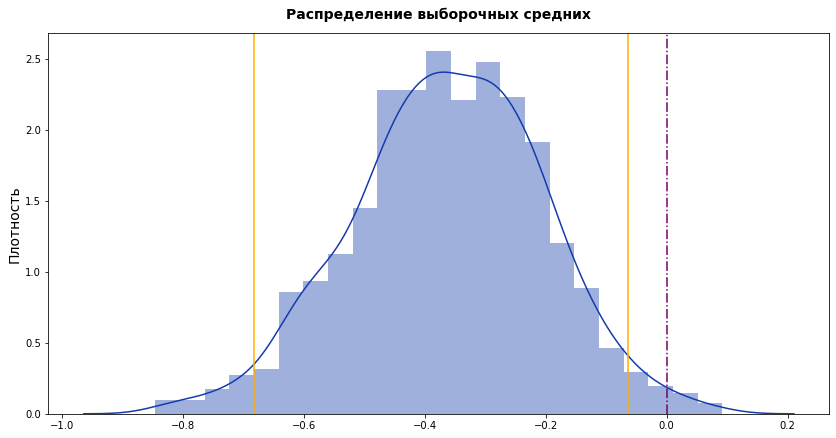

In [46]:
buf = []
for i in range(1000):
    a_sample = data.loc[data['Q2'].isin([1, 2, 3])]['Downlink TCP Retransmission Rate(%)'].sample(100)
    b_sample = main_2.loc[main_2['Q1'].isin([9, 10])]['Downlink TCP Retransmission Rate(%)'].sample(100)
    buf.append(np.mean(b_sample)-np.mean(a_sample))
    
ax_buf = sns.distplot(buf, color = '#133AAC')
ax_buf.axvline(np.percentile(buf,2.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(np.percentile(buf,97.5),linestyle = '-', color='#FFAE00')
ax_buf.axvline(0, color = '#730065', linestyle  = '-.')
plt.title('Распределение выборочных средних', fontsize = 14, fontweight = 'bold', pad = 15)
plt.ylabel('Плотность', fontsize = 14);

In [47]:
# применим t-тест 
stat, p = ttest_ind(group_a, group_b)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Различий в выборках нет, принимем Ho')
else:
    print('Различия в выборках есть, отвергаем Ho')


Statistics=106.259, p=0.000
Различия в выборках есть, отвергаем Ho


### Вывод: Ноль не входит в доверительный интервал, p_value меньше 0.05, значит можно сделать вывод, что различия между группой В где оценили связь на 9 или 10 баллов и той группой которую не устраивали показатели не связанные с техническими данными в таблице существенная. Показатель Downlink TCP Retransmission Rate(%) влияет на удовлетворенность пользователей. 

Попробуем узнать в какие показатели существенно различаются между группами опрошенных, 

- первая группа - те, кто полностью не доволен связью (поставили после первого вопроса 1) 
- вторая группа - те, которые дал другой ответ

In [49]:
# отбор записей, где полностью недовольные пользователи, на первый вопрос ответили 1
d_1 = data[data['Q1'] == 1].groupby('Q1').mean().reset_index().drop('Q2', axis= 1)
d_1.head()

Q1  Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
0  1.0         392.881936                1568.530794               136.007444   

   Downlink TCP Retransmission Rate(%)  \
0                             2.008476   

   Video Streaming Download Throughput(Kbps)  \
0                                4006.316631   

   Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
0                          2259.339056                         1517.902514   

   Web Average TCP RTT(ms)  
0               226.368195

In [51]:
# убираем ненужные строки 
data_2 = data.loc[~data['Q2'].isin([0, 6, 7, 27, 34, 10])]

# фильтр по записям, во избежание дублирования убираем записи где на Q1 дан ответ 1 
d_2 = data_2[data_2['Q1'] != 1].groupby('Q2').mean().reset_index().drop('Q1', axis= 1)
d_2.head()

Q2  Total Traffic(MB)  Downlink Throughput(Kbps)  Uplink Throughput(Kbps)  \
0   1         402.365078                1933.635280               163.460985   
1   2         406.113129                1780.041985               155.448709   
2   3         408.615909                1877.648655               147.297761   
3   4         421.756239                1668.486635               145.139253   
4   5         422.732613                1468.724950               125.086973   

   Downlink TCP Retransmission Rate(%)  \
0                             1.679516   
1                             1.776833   
2                             1.759049   
3                             1.795450   
4                             1.859389   

   Video Streaming Download Throughput(Kbps)  \
0                                5445.351202   
1                                5094.582858   
2                                5110.250224   
3                                4571.645316   
4                                3996.511935   

   Video Streaming xKB Start Delay(ms)  Web Page Download Throughput(Kbps)  \
0                          2050.406075                         1965.141897   
1                          1966.094171                         2018.402500   
2                          2009.490504                         1889.771735   
3                          2184.902597                         1671.987976   
4                          2177.175613                         1456.935946   

   Web Average TCP RTT(ms)  
0               161.424910  
1               156.619291  
2               160.742456  
3               184.135981  
4               197.115371

Найдем разницу в процентах между средними значениями технических показателей по группами (во второй группе берем среднее значение вне зависимости от оценки)

In [52]:
for col_1 in d_1.iloc[:, 1:]:
    for col_2 in d_2.iloc[:, 1:]:
        if col_1 == col_2:
            res = ((d_1[col_1][0] - d_2[col_2].mean()) / d_1[col_2].mean()) * 100
            print(f'{round(res,3)}% колонка {col_1}')


-4.947% колонка Total Traffic(MB)
-11.296% колонка Downlink Throughput(Kbps)
-8.293% колонка Uplink Throughput(Kbps)
11.672% колонка Downlink TCP Retransmission Rate(%)
-20.901% колонка Video Streaming Download Throughput(Kbps)
8.043% колонка Video Streaming xKB Start Delay(ms)
-18.614% колонка Web Page Download Throughput(Kbps)
24.014% колонка Web Average TCP RTT(ms)


Наиболее существенные различия в колонке Web Average TCP RTT(ms).

Эти различия могли ли повлиять на оценку, которую поставили респонденты?

652 1731
H-statistic = 37.82010130413596, p_value = 0.0


C:\Users\e.boykova\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\e.boykova\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



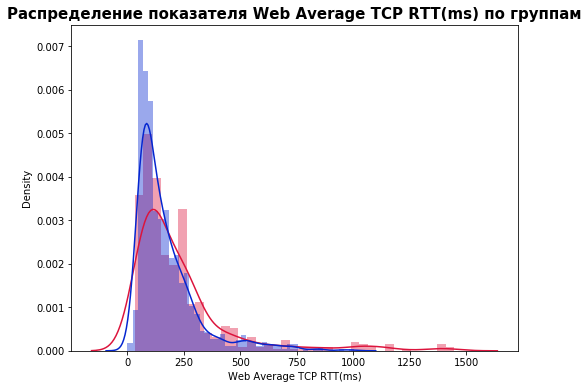

In [45]:
# первая группа, те кто поставил 1 после первого вопроса 
gr_1 = data_2[data_2['Q1'] == 1]['Web Average TCP RTT(ms)']
# вторая группа, оставшиеся пользователи 
gr_2 = data_2[data_2['Q1'] != 1]['Web Average TCP RTT(ms)']

print(len(gr_1), len(gr_2))
# поскольку выборки разного размера и не имеют нормального распределения 
# применим критерий Краскела - Уоллиса (как уже было выше)

fig,ax =  plt.subplots(figsize=(8,6))
sns.distplot(gr_1, color = '#DC143C')
sns.distplot(gr_2, color = '#0426d0')
plt.title('Распределение показателя Web Average TCP RTT(ms) по группам', fontweight = 'bold', fontsize = 15)

# применение Н-критерия 
stat, p = stats.kruskal(gr_1, gr_2)
print(f'H-statistic = {stat}, p_value = {round(p,4)}')

### Вывод: группы в одной из которых пользователи оценили связь на 1 балл, а в другой были все остальные пользователи различия статистически значимы. Показатель Web Average TCP RTT(ms) влияет но оценку, так как p-value < 0.05

In [53]:
# если посчитать p-value для всех показателей разных групп, то выяснится не то что бы новость, 
# все показатели важны, только 2 из них меньше чем остальные где p-value(округлённое) > 0 
# (Total Traffic(MB), Downlink TCP Retransmission Rate(%))
p = data[data['Q1'] == 1]
v = data_2[data_2['Q1'] != 1]

for i in p.iloc[:, 2:]:
    for j in v.iloc[:, 2:]:
        if i == j:
            a = p[i]
            b = v[j]
            
            stat, p_val = stats.kruskal(a, b)
            print(f'H-statistic = {stat}, p_value = {round(p_val,4)}, колонка {i}')

H-statistic = 6.188129515998348, p_value = 0.0129, колонка Total Traffic(MB)
H-statistic = 17.79383737255015, p_value = 0.0, колонка Downlink Throughput(Kbps)
H-statistic = 17.074338473640154, p_value = 0.0, колонка Uplink Throughput(Kbps)
H-statistic = 5.785538908006652, p_value = 0.0162, колонка Downlink TCP Retransmission Rate(%)
H-statistic = 38.67839856355106, p_value = 0.0, колонка Video Streaming Download Throughput(Kbps)
H-statistic = 23.519452688365288, p_value = 0.0, колонка Video Streaming xKB Start Delay(ms)
H-statistic = 37.164947534380374, p_value = 0.0, колонка Web Page Download Throughput(Kbps)
H-statistic = 34.18118832033105, p_value = 0.0, колонка Web Average TCP RTT(ms)


In [66]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [67]:
# посмотрим на связь различных показателей с объемом трафика
# все данные перед отображением логарифмируются

df_chart = df.drop(['user_id', 'Q1', 'Q2'], axis =1)


x = df_chart['Total Traffic(MB)'].sort_values()
y = df_chart.columns.to_list()[1:]
paper = go.Figure()

for i in y:
    y = df_chart[i]
    paper.add_trace(
        go.Scatter(
            x = np.log(x),
            y = np.log(y),
            name = str(i),
            mode='markers'
        )
    )
    
paper.update_layout(
    title='Зависимость показателей от общего объема трафика (log)',
    xaxis_title='Объем трафика (log)')


paper.show()


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



**Из графика можно сделать вывод, что вне зависимости от суммарного объема трафика все показатели равномерно распределены. То есть увеличение трафика не влияет увеличение других показателей**

In [68]:
# делаем глубокую копию дф
df_anova = main.copy(deep=True)

# переименуем интересующие нас столбцы, иначе дальше будут капризы из-за пробелов 
df_anova.columns = [i.replace(' ', '_') for i in main.columns.to_list()]
df_anova.rename(columns=lambda x: x.partition('(')[0].lower(), inplace=True)

df_anova.head()

q1       q2  total_traffic  downlink_throughput  uplink_throughput  \
0  B      NaN      775.48846               360.13              86.56   
1  B        4      861.96324              3023.54             411.18   
2  B        4      261.11860               790.96              34.20   
3  B        3      179.18564              2590.97             325.88   
4  B  2, 3, 4      351.99208               731.61             223.54   

   downlink_tcp_retransmission_rate  video_streaming_download_throughput  \
0                              3.93                              1859.15   
1                              1.27                               667.47   
2                              1.79                              1079.60   
3                              0.80                              7053.81   
4                              1.15                              4550.38   

   video_streaming_xkb_start_delay  web_page_download_throughput  \
0                           2309.0                       1007.82   
1                           2080.0                        255.36   
2                           6367.0                        535.85   
3                           3218.0                       1221.02   
4                           1767.0                       2336.56   

   web_average_tcp_rtt  
0                 83.0  
1                425.0  
2                485.0  
3                 51.0  
4                 68.0

In [69]:
# удалим столбец который нет смысла анализировать в данной задаче
df_anova = df_anova.drop(['q2'], axis = 1)

# группе А присвоим код 1, группе В код 2, так как модуль работает только с цифрами
df_anova['q1'] = np.where(df_anova['q1'] == 'A', 1, 2)

In [70]:
# проверка 
df_anova['q1'].value_counts()

2    1974
1     238
Name: q1, dtype: int64

**Далее проведем анализ**


Для этого нам нужно подготовить список пар параметров для оценки их совместного влияния на оценку, с помощью модуля itertools найдем все возможные парные комбинации параметров и сохраним их в переменной pair

In [73]:
from itertools import combinations
lq = combinations(df_anova.columns.to_list()[1:], 2)
pair = list(lq)

В model будет список из pair но в формате, который необходим для работы, пары которые проверяем на взаимодействие записаны через ':', на первой позиции стоит элемент q1 будем проверять какие пары параметров влияют на оценку. 

In [74]:
model = ols("q1 ~ total_traffic:downlink_throughput \
    +total_traffic:uplink_throughput \
    +total_traffic:downlink_tcp_retransmission_rate \
    +total_traffic:video_streaming_download_throughput \
    +total_traffic:video_streaming_xkb_start_delay \
    +total_traffic:web_page_download_throughput \
    +total_traffic:web_average_tcp_rtt \
    +downlink_throughput:uplink_throughput \
    +downlink_throughput:downlink_tcp_retransmission_rate \
    +downlink_throughput:video_streaming_download_throughput \
    +downlink_throughput:video_streaming_xkb_start_delay \
    +downlink_throughput:web_page_download_throughput \
    +downlink_throughput:web_average_tcp_rtt \
    +uplink_throughput:downlink_tcp_retransmission_rate \
    +uplink_throughput:video_streaming_download_throughput \
    +uplink_throughput:video_streaming_xkb_start_delay \
    +uplink_throughput:web_page_download_throughput \
    +uplink_throughput:web_average_tcp_rtt \
    +downlink_tcp_retransmission_rate:video_streaming_download_throughput \
    +downlink_tcp_retransmission_rate:video_streaming_xkb_start_delay \
    +downlink_tcp_retransmission_rate:web_page_download_throughput \
    +downlink_tcp_retransmission_rate:web_average_tcp_rtt \
    +video_streaming_download_throughput:video_streaming_xkb_start_delay \
    +video_streaming_download_throughput:web_page_download_throughput \
    +video_streaming_download_throughput:web_average_tcp_rtt \
    +video_streaming_xkb_start_delay:web_page_download_throughput \
    +video_streaming_xkb_start_delay:web_average_tcp_rtt \
    +web_page_download_throughput:web_average_tcp_rtt ", data = df_anova).fit()


anova_table=anova_lm(model)

In [76]:
# отберем записи, где p_value ниже 0.06
tab = anova_table[anova_table['PR(>F)'] < 0.06].sort_values(by = 'PR(>F)')
tab

df    sum_sq   mean_sq  \
downlink_throughput:video_streaming_download_th...  1.0  1.619904  1.619904   
downlink_throughput:web_page_download_throughput    1.0  1.316875  1.316875   
total_traffic:downlink_tcp_retransmission_rate      1.0  1.301942  1.301942   
uplink_throughput:downlink_tcp_retransmission_rate  1.0  0.923630  0.923630   
downlink_throughput:uplink_throughput               1.0  0.683798  0.683798   
total_traffic:uplink_throughput                     1.0  0.654530  0.654530   
uplink_throughput:video_streaming_xkb_start_delay   1.0  0.505498  0.505498   
video_streaming_download_throughput:web_average...  1.0  0.364047  0.364047   
total_traffic:video_streaming_xkb_start_delay       1.0  0.341673  0.341673   

                                                            F    PR(>F)  
downlink_throughput:video_streaming_download_th...  17.454352  0.000031  
downlink_throughput:web_page_download_throughput    14.189230  0.000170  
total_traffic:downlink_tcp_retransmission_rate      14.028325  0.000185  
uplink_throughput:downlink_tcp_retransmission_rate   9.952049  0.001629  
downlink_throughput:uplink_throughput                7.367875  0.006692  
total_traffic:uplink_throughput                      7.052516  0.007973  
uplink_throughput:video_streaming_xkb_start_delay    5.446701  0.019696  
video_streaming_download_throughput:web_average...   3.922585  0.047767  
total_traffic:video_streaming_xkb_start_delay        3.681497  0.055150

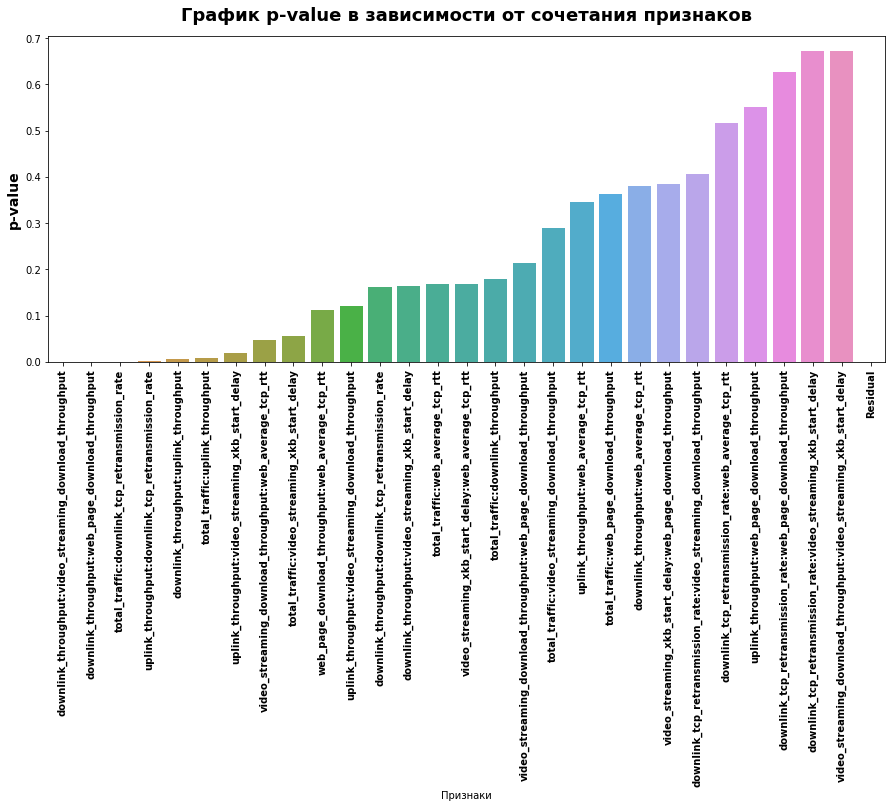

In [78]:
# построим график p_value
anova_table_plot = anova_table.sort_values(by='PR(>F)')

plt.figure(figsize=(15, 6))
sns.barplot(x=anova_table_plot.index, y='PR(>F)', data=anova_table_plot)
plt.xticks(rotation=90, fontweight='bold')
plt.xlabel('Признаки')
plt.ylabel('p-value', fontsize=14, fontweight='bold')
plt.title('График p-value в зависимости от сочетания признаков', fontsize=18, fontweight='bold', pad=15);

In [57]:
list(tab.reset_index()['index'])

['downlink_throughput:video_streaming_download_throughput',
 'downlink_throughput:web_page_download_throughput',
 'total_traffic:downlink_tcp_retransmission_rate',
 'uplink_throughput:downlink_tcp_retransmission_rate',
 'downlink_throughput:uplink_throughput',
 'total_traffic:uplink_throughput',
 'uplink_throughput:video_streaming_xkb_start_delay',
 'video_streaming_download_throughput:web_average_tcp_rtt',
 'total_traffic:video_streaming_xkb_start_delay']

#### Из таблицы можно сделать вывод, что совместное влияние пар параметров:
- 'downlink_throughput:video_streaming_download_throughput',
- 'downlink_throughput:web_page_download_throughput',
- 'total_traffic:downlink_tcp_retransmission_rate',
- 'uplink_throughput:downlink_tcp_retransmission_rate',
- 'downlink_throughput:uplink_throughput',
- 'total_traffic:uplink_throughput',
- 'uplink_throughput:video_streaming_xkb_start_delay',
- 'video_streaming_download_throughput:web_average_tcp_rtt',
- 'total_traffic:video_streaming_xkb_start_delay'

Cтатистически значимо влияют на оценку респондентов, которую они поставили после первого вопроса.  

### Проверим, какие факторы влияют на оценку респондентов которым задали второй вопрос.
(в целом код повторяется только меняется q1 на q2 в модели)

In [79]:
# переименуем интересующие нас столбцы, иначе дальше будут капризы из-за пробелов 
q2.columns = [i.replace(' ', '_') for i in q2.columns.to_list()]
q2.rename(columns=lambda x: x.partition('(')[0].lower(), inplace=True)

In [80]:
model_2 = ols("q2 ~ total_traffic:downlink_throughput \
    +total_traffic:uplink_throughput \
    +total_traffic:downlink_tcp_retransmission_rate \
    +total_traffic:video_streaming_download_throughput \
    +total_traffic:video_streaming_xkb_start_delay \
    +total_traffic:web_page_download_throughput \
    +total_traffic:web_average_tcp_rtt \
    +downlink_throughput:uplink_throughput \
    +downlink_throughput:downlink_tcp_retransmission_rate \
    +downlink_throughput:video_streaming_download_throughput \
    +downlink_throughput:video_streaming_xkb_start_delay \
    +downlink_throughput:web_page_download_throughput \
    +downlink_throughput:web_average_tcp_rtt \
    +uplink_throughput:downlink_tcp_retransmission_rate \
    +uplink_throughput:video_streaming_download_throughput \
    +uplink_throughput:video_streaming_xkb_start_delay \
    +uplink_throughput:web_page_download_throughput \
    +uplink_throughput:web_average_tcp_rtt \
    +downlink_tcp_retransmission_rate:video_streaming_download_throughput \
    +downlink_tcp_retransmission_rate:video_streaming_xkb_start_delay \
    +downlink_tcp_retransmission_rate:web_page_download_throughput \
    +downlink_tcp_retransmission_rate:web_average_tcp_rtt \
    +video_streaming_download_throughput:video_streaming_xkb_start_delay \
    +video_streaming_download_throughput:web_page_download_throughput \
    +video_streaming_download_throughput:web_average_tcp_rtt \
    +video_streaming_xkb_start_delay:web_page_download_throughput \
    +video_streaming_xkb_start_delay:web_average_tcp_rtt \
    +web_page_download_throughput:web_average_tcp_rtt ", data = q2).fit()


anova_table_2=anova_lm(model_2)

In [81]:
tab_2 = anova_table_2[anova_table_2['PR(>F)'] < 0.06].sort_values(by = 'PR(>F)')
tab_2

df     sum_sq    mean_sq  \
total_traffic:downlink_tcp_retransmission_rate      1.0  18.738312  18.738312   
uplink_throughput:video_streaming_xkb_start_delay   1.0  12.452795  12.452795   
downlink_throughput:video_streaming_download_th...  1.0   9.349297   9.349297   
uplink_throughput:downlink_tcp_retransmission_rate  1.0   8.338505   8.338505   
total_traffic:video_streaming_xkb_start_delay       1.0   7.987180   7.987180   
total_traffic:downlink_throughput                   1.0   7.717007   7.717007   
downlink_throughput:downlink_tcp_retransmission...  1.0   7.545421   7.545421   
uplink_throughput:video_streaming_download_thro...  1.0   6.181960   6.181960   

                                                            F    PR(>F)  
total_traffic:downlink_tcp_retransmission_rate      10.745878  0.001060  
uplink_throughput:video_streaming_xkb_start_delay    7.141316  0.007585  
downlink_throughput:video_streaming_download_th...   5.361550  0.020671  
uplink_throughput:downlink_tcp_retransmission_rate   4.781890  0.028859  
total_traffic:video_streaming_xkb_start_delay        4.580416  0.032442  
total_traffic:downlink_throughput                    4.425480  0.035512  
downlink_throughput:downlink_tcp_retransmission...   4.327080  0.037618  
uplink_throughput:video_streaming_download_thro...   3.545174  0.059842

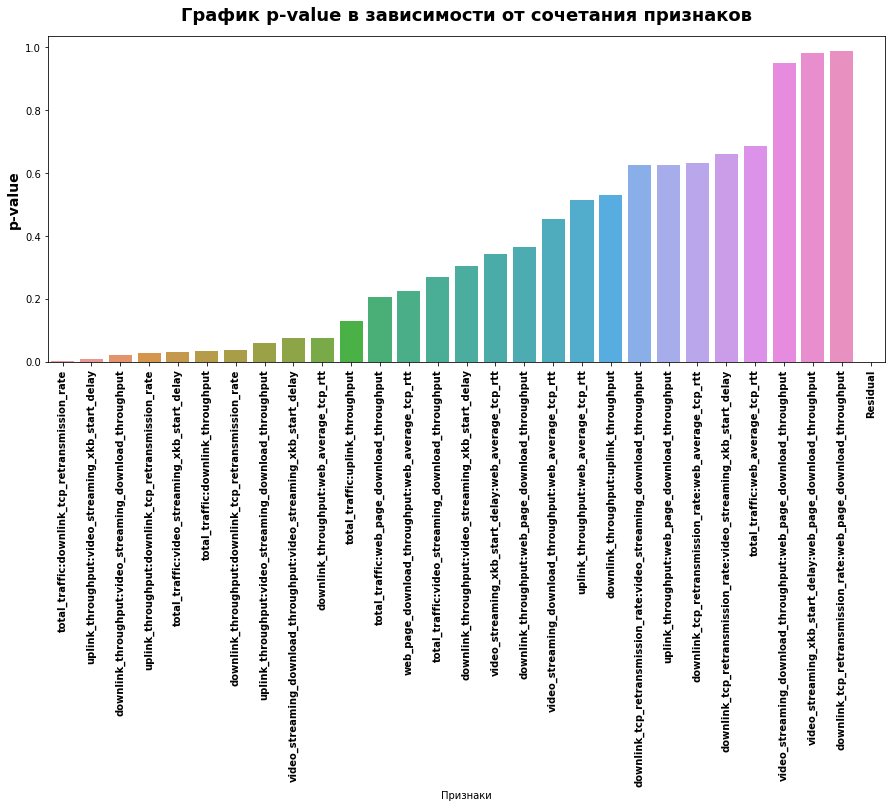

In [82]:
# построим график p_value
anova_table_plot = anova_table_2.sort_values(by='PR(>F)')

plt.figure(figsize=(15, 6))
sns.barplot(x=anova_table_plot.index, y='PR(>F)', data=anova_table_plot)
plt.xticks(rotation=90, fontweight='bold')
plt.xlabel('Признаки')
plt.ylabel('p-value', fontsize=14, fontweight='bold')
plt.title('График p-value в зависимости от сочетания признаков', fontsize=18, fontweight='bold', pad=15);

**Наибольшее влияние на оценку оказывает сочетание следующих параметров**

In [83]:
tab_2.index

Index(['total_traffic:downlink_tcp_retransmission_rate',
       'uplink_throughput:video_streaming_xkb_start_delay',
       'downlink_throughput:video_streaming_download_throughput',
       'uplink_throughput:downlink_tcp_retransmission_rate',
       'total_traffic:video_streaming_xkb_start_delay',
       'total_traffic:downlink_throughput',
       'downlink_throughput:downlink_tcp_retransmission_rate',
       'uplink_throughput:video_streaming_download_throughput'],
      dtype='object')